In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from curvemetrics.datafetcher import DataFetcher
from curvemetrics.metricsprocessor import MetricsProcessor
import timeit
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from web3 import Web3
import matplotlib.pyplot as plt
from curvemetrics.datahandler import RawDataHandler
import json
from curvemetrics.queries import queries
import ccxt
from dotenv import load_dotenv
import os

In [3]:
def load_config():
    # Load the configuration
    with open(os.path.join(os.path.abspath('config.json')), "r") as config_file:
        config = json.load(config_file)
    return config

INFURA_KEY = os.getenv("INFURA_KEY")
config = load_config()

In [4]:
datahandler = RawDataHandler()
token_metadata = datahandler.get_token_metadata()
pool_metadata = datahandler.get_pool_metadata()
metricsprocessor = MetricsProcessor(pool_metadata, token_metadata)

Executing: SELECT * FROM tokens...
Executing: SELECT * FROM pools...


In [28]:
pool = "0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7"
ust = "0xa693b19d2931d498c5b318df961919bb4aee87a5"
usdc = "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48"
start = datetime.timestamp(datetime(2022, 1, 1))
end=datetime.timestamp(datetime(2022, 1, 10))

In [73]:
pool_data = datahandler.get_pool_data(pool, start, end)
swaps_data = datahandler.get_swaps_data(pool, start, end)
lp_data = datahandler.get_lp_data(pool, start, end)
token_ohlcv = datahandler.get_ohlcv_data(ust, start, end)

Executing: SELECT * FROM pool_data WHERE pool_id=? AND approxTimestamp >= ? AND approxTimestamp <= ? ORDER BY approxTimestamp ASC...
Executing: SELECT * FROM swaps WHERE pool_id=? AND timestamp >= ? AND timestamp <= ? ORDER BY timestamp ASC...
Executing: SELECT * FROM lp_events WHERE pool_id=? AND timestamp >= ? AND timestamp <= ? ORDER BY timestamp ASC...
Executing: SELECT * FROM token_ohlcv WHERE token_id=? AND timestamp >= ? AND timestamp <= ? ORDER BY timestamp ASC...


In [71]:
pool_metrics = metricsprocessor.process_metrics_for_pool(pool, pool_data, swaps_data, lp_data)
pool_metrics.head()

,giniCoefficient,shannonsEntropy,DAI.netSwapFlow,DAI.netLPFlow,USDC.netSwapFlow,USDC.netLPFlow,USDT.netSwapFlow,USDT.netLPFlow
2022-01-01 00:00:00,0.052236,1.577167,0.0,0,0.000000,0.000000e+00,0.000000,-2.734864e+11
2022-01-01 00:01:00,0.052072,1.577210,0.0,0,438045.435692,0.000000e+00,-438120.697287,0.000000e+00
2022-01-01 00:02:00,0.052153,1.577187,0.0,-2242466139001349912636,0.000000,7.095279e+11,0.000000,0.000000e+00
2022-01-01 00:03:00,0.052201,1.577177,0.0,0,0.000000,-1.590062e+08,0.000000,0.000000e+00
2022-01-01 00:04:00,0.052241,1.577166,0.0,0,0.000000,0.000000e+00,0.000000,0.000000e+00


In [176]:
for pool in pool_metadata:
    symbol = pool_metadata[pool]['symbol'].replace("/", "-")
    print(symbol)
    pool_data = pd.read_csv(f"./data/rawdata/{symbol}_pool_data.csv")
    pool_data['inputTokenWeights'] = pool_data['inputTokenWeights'].apply(json.loads)
    pool_data['inputTokenBalances'] = pool_data['inputTokenBalances'].apply(json.loads)
    pool_data = pool_data.set_index(pd.to_datetime(pool_data['approxTimestamp']))
    swaps_data = pd.read_csv(f"./data/rawdata/{symbol}_swaps.csv")
    lp_data = pd.read_csv(f"./data/rawdata/{symbol}_lp_events.csv")
    pool_metrics = metricsprocessor.process_metrics_for_pool(pool, pool_data, swaps_data, lp_data)
    pool_metrics.to_csv(f"./data/newmetrics/{symbol}_metrics.csv")

for token in token_metadata:
    try:
        symbol = token_metadata[token]['symbol']
        print(symbol)
        token_ohlcv = pd.read_csv(f"./data/rawdata/{symbol}_ohlcv.csv")
        token_ohlcv = token_ohlcv.set_index(pd.to_datetime(token_ohlcv['timestamp']))
        token_ohlcv = token_ohlcv.sort_index()
        token_metrics = metricsprocessor.process_metrics_for_token(token, token_ohlcv)
        token_metrics.to_csv(f"./data/newmetrics/{symbol}_metrics.csv")
    except Exception as e:
        print(f"{e}")

3Crv
steCRV
crvFRAX
UST_whv23CRV-f
usdn3CRV
MIM-3LP3CRV-f
crvPlain3andSUSD
frxETHCRV
LUSD3CRV-f
BUSD3CRV-f
STETHETH_C-f
cbETH-ETH-f
cvxcrv-crv-f
stETH
[Errno 2] No such file or directory: './data/rawdata/stETH_ohlcv.csv'
USDT
3Crv
[Errno 2] No such file or directory: './data/rawdata/3Crv_ohlcv.csv'
USDC
sUSD
[Errno 2] No such file or directory: './data/rawdata/sUSD_ohlcv.csv'
WETH
[Errno 2] No such file or directory: './data/rawdata/WETH_ohlcv.csv'
UST
[Errno 2] No such file or directory: './data/rawdata/UST_ohlcv.csv'
DAI
MIM
frxETH
[Errno 2] No such file or directory: './data/rawdata/frxETH_ohlcv.csv'
ETH
cbETH
LUSD
[Errno 2] No such file or directory: './data/rawdata/LUSD_ohlcv.csv'
USDN
[Errno 2] No such file or directory: './data/rawdata/USDN_ohlcv.csv'
FRAX
BUSD
CRV
cvxCRV
[Errno 2] No such file or directory: './data/rawdata/cvxCRV_ohlcv.csv'


In [177]:
]

{'0xae7ab96520de3a18e5e111b5eaab095312d7fe84': {'name': 'Liquid staked Ether 2.0',
  'symbol': 'stETH',
  'decimals': 18,
  'id': '0xae7ab96520de3a18e5e111b5eaab095312d7fe84'},
 '0xdac17f958d2ee523a2206206994597c13d831ec7': {'name': 'Tether USD',
  'symbol': 'USDT',
  'decimals': 6,
  'id': '0xdac17f958d2ee523a2206206994597c13d831ec7'},
 '0x6c3f90f043a72fa612cbac8115ee7e52bde6e490': {'name': 'Curve.fi DAI/USDC/USDT',
  'symbol': '3Crv',
  'decimals': 18,
  'id': '0x6c3f90f043a72fa612cbac8115ee7e52bde6e490'},
 '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48': {'name': 'USD Coin',
  'symbol': 'USDC',
  'decimals': 6,
  'id': '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48'},
 '0x57ab1ec28d129707052df4df418d58a2d46d5f51': {'name': 'Synth sUSD',
  'symbol': 'sUSD',
  'decimals': 18,
  'id': '0x57ab1ec28d129707052df4df418d58a2d46d5f51'},
 '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2': {'name': 'Wrapped Ether',
  'symbol': 'WETH',
  'decimals': 18,
  'id': '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2'

In [178]:
busd = '0x4fabb145d64652a948d72533023f6e7a623c7c53'
symbol = token_metadata[busd]['symbol']
token_ohlcv = pd.read_csv(f"./data/rawdata/{symbol}_ohlcv.csv")
token_ohlcv

,timestamp,id,token_id,symbol,timestamp.1,open,high,low,close,volume
0,2023-03-01 00:01:00,52373,0x4fabb145d64652a948d72533023f6e7a623c7c53,BUSD/USD,1677628860,0.9999,0.9999,0.9999,0.9999,0.0
1,2023-03-01 00:01:00,80491,0x4fabb145d64652a948d72533023f6e7a623c7c53,BUSD/USD,1677628860,0.9999,0.9999,0.9999,0.9999,0.0
2,2023-03-01 00:01:00,66432,0x4fabb145d64652a948d72533023f6e7a623c7c53,BUSD/USD,1677628860,0.9999,0.9999,0.9999,0.9999,0.0
3,2023-03-01 00:02:00,80492,0x4fabb145d64652a948d72533023f6e7a623c7c53,BUSD/USD,1677628920,0.9999,0.9999,0.9999,0.9999,0.0
4,2023-03-01 00:02:00,66433,0x4fabb145d64652a948d72533023f6e7a623c7c53,BUSD/USD,1677628920,0.9999,0.9999,0.9999,0.9999,0.0
...,...,...,...,...,...,...,...,...,...,...
71619,2023-03-30 02:55:00,461622,0x4fabb145d64652a948d72533023f6e7a623c7c53,BUSD/USD,1680144900,1.0000,1.0000,1.0000,1.0000,0.0
71620,2023-03-30 02:56:00,461623,0x4fabb145d64652a948d72533023f6e7a623c7c53,BUSD/USD,1680144960,1.0000,1.0000,1.0000,1.0000,0.0
71621,2023-03-30 02:57:00,461624,0x4fabb145d64652a948d72533023f6e7a623c7c53,BUSD/USD,1680145020,1.0000,1.0000,1.0000,1.0000,0.0
71622,2023-03-30 02:58:00,461625,0x4fabb145d64652a948d72533023f6e7a623c7c53,BUSD/USD,1680145080,0.9997,0.9997,0.9997,0.9997,9612.0


In [174]:
foo = pd.read_csv("./data/newmetrics/USDC_metrics.csv")
foo

,Unnamed: 0,giniCoefficient,shannonsEntropy,CRV.netSwapFlow,CRV.netLPFlow,cvxCRV.netSwapFlow,cvxCRV.netLPFlow
0,2023-03-08 23:55:00,0.369542,0.558693,0.0,0,0.0,0
1,2023-03-08 23:56:00,0.369542,0.558693,0.0,0,0.0,0
2,2023-03-08 23:57:00,0.369542,0.558693,0.0,0,0.0,0
3,2023-03-08 23:58:00,0.369542,0.558693,0.0,0,0.0,0
4,2023-03-08 23:59:00,0.369542,0.558693,0.0,0,0.0,0
...,...,...,...,...,...,...,...
34561,2023-04-01 23:56:00,0.368145,0.562503,0.0,0,0.0,0
34562,2023-04-01 23:57:00,0.368145,0.562503,0.0,0,0.0,0
34563,2023-04-01 23:58:00,0.368145,0.562503,0.0,0,0.0,0
34564,2023-04-01 23:59:00,0.368145,0.562503,0.0,0,0.0,0


<Axes: >

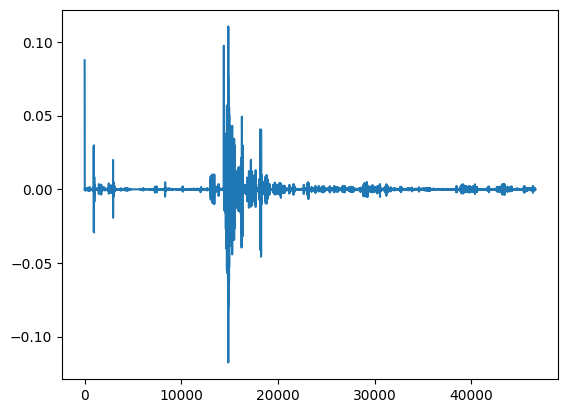

In [171]:
foo = pd.read_csv("./data/metrics/USDC.csv")
foo['USDC.logReturns'].plot()

In [77]:
token_metrics = metricsprocessor.process_metrics_for_token(ust, token_ohlcv)
token_metrics.head()

,UST.logReturns
timestamp,
2022-01-01 00:01:00,0.000000
2022-01-01 00:02:00,0.000999
2022-01-01 00:03:00,0.000000
2022-01-01 00:04:00,-0.000999
2022-01-01 00:05:00,0.000999


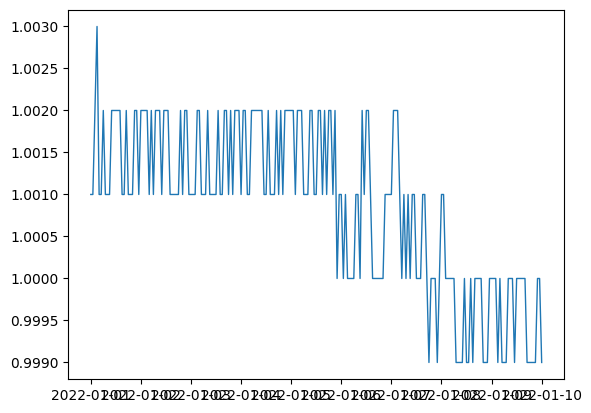

In [93]:
f, ax = plt.subplots()
foo = token_ohlcv.resample('1h').last()
ax.plot(foo.index, foo.close, linewidth=1)

In [20]:
for pool, metadata in pool_metadata.items():
    pool_name = metadata['symbol'].replace('/', '-')

    pool_data = datahandler.get_pool_data(pool)
    pool_data.to_csv(f"./data/rawdata/{pool_name}_pool_data.csv")

    lp_events = datahandler.get_lp_data(pool)
    lp_events.to_csv(f"./data/rawdata/{pool_name}_lp_events.csv")

    swaps = datahandler.get_swaps_data(pool)
    swaps.to_csv(f"./data/rawdata/{pool_name}_swaps.csv")

In [41]:
for token in token_metadata:
    try:
        metrics_for_token(token, datahandler, token_metadata)
    except:
        print(f"Error for token {token_metadata[token]['symbol']}")

Error for token frxETH
Error for token UST
Error for token cvxCRV
Error for token sUSD
Error for token WETH
Error for token stETH
Error for token 3Crv
Error for token LUSD
Error for token USDN


In [45]:
for pool in pool_metadata:
    try:
        print(f"Processing pool {pool_metadata[pool]['symbol']}")
        metrics_for_pool(pool, datahandler, pool_metadata, token_metadata)
    except Exception as e:
        print(f"Error for pool {pool_metadata[pool]['symbol']}: {e}")

Processing pool 3Crv
Processing pool steCRV
Processing pool crvFRAX
Processing pool UST_whv23CRV-f
Processing pool usdn3CRV
Processing pool MIM-3LP3CRV-f
Processing pool crvPlain3andSUSD
Processing pool frxETHCRV
Processing pool LUSD3CRV-f
Processing pool BUSD3CRV-f
Processing pool STETHETH_C-f
Processing pool cbETH/ETH-f
Error for pool cbETH/ETH-f: Cannot save file into a non-existent directory: 'tmpdata/cbETH'
Processing pool cvxcrv-crv-f


In [15]:
pool_data = datahandler.get_pool_data(pool)
swaps_data = datahandler.get_swaps_data(pool)
lp_data = datahandler.get_lp_data(pool)

<Axes: xlabel='timestamp'>

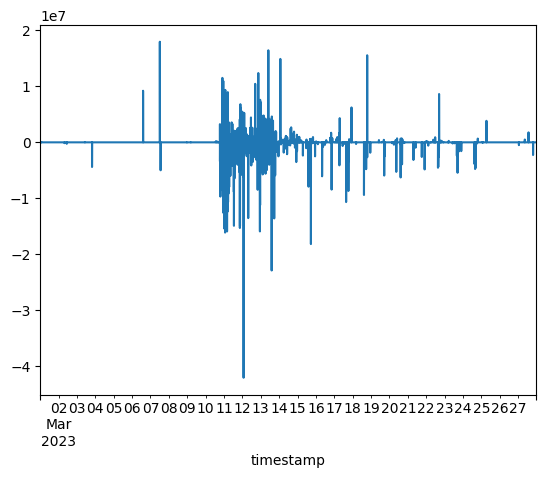

In [25]:
gini_data = gini(pool_data)
shannon_data = shannons_entropy(pool_data)

metrics = []

for token_idx, token_id in enumerate(pool_metadata[pool]['coins']):
    token_ohlcv = datahandler.get_ohlcv_data(token_id)
    metrics.append(net_swap_flow(swaps_data, token_id, token_metadata[token_id]['symbol']))
    metrics.append(net_lp_flow(lp_data, token_idx, token_metadata[token_id]['symbol']))
    metrics.append(log_returns(token_ohlcv, token_metadata[token_id]['symbol']))
metrics_df = pd.concat(metrics, axis=1)
metrics_df = metrics_df.fillna(0)

In [104]:
metrics_df

,giniCoefficient,shannonsEntropy,DAI.netSwapFlow,USDC.netSwapFlow,USDT.netSwapFlow,DAI.netLPFlow,USDC.netLPFlow,USDT.netLPFlow,DAI.logReturns,USDC.logReturns,USDT.logReturns
2023-03-10 00:00:00,0.063709,1.573687,0.000000,0.0000,0.00000,0.0,0.0,0.0,0.000000,0.0000,0.0
2023-03-10 00:01:00,0.063601,1.573742,149886.959338,-151891.9253,1992.02007,0.0,0.0,0.0,0.007414,0.0007,0.0
2023-03-10 00:02:00,0.063601,1.573742,0.000000,0.0000,0.00000,0.0,0.0,0.0,0.000000,0.0008,0.0
2023-03-10 00:03:00,0.063601,1.573742,0.000000,0.0000,0.00000,0.0,0.0,0.0,0.000000,0.0000,0.0
2023-03-10 00:04:00,0.064507,1.573233,0.000000,0.0000,0.00000,0.0,0.0,0.0,0.000000,0.0000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-10 16:36:00,0.000000,0.000000,0.000000,0.0000,0.00000,0.0,0.0,0.0,-0.011722,0.0000,0.0
2023-03-10 16:37:00,0.000000,0.000000,0.000000,0.0000,0.00000,0.0,0.0,0.0,0.000000,0.0000,0.0
2023-03-10 16:38:00,0.000000,0.000000,0.000000,0.0000,0.00000,0.0,0.0,0.0,0.000000,0.0000,0.0
2023-03-10 16:39:00,0.000000,0.000000,0.000000,0.0000,0.00000,0.0,0.0,0.0,0.000000,-0.0008,0.0


<Axes: >

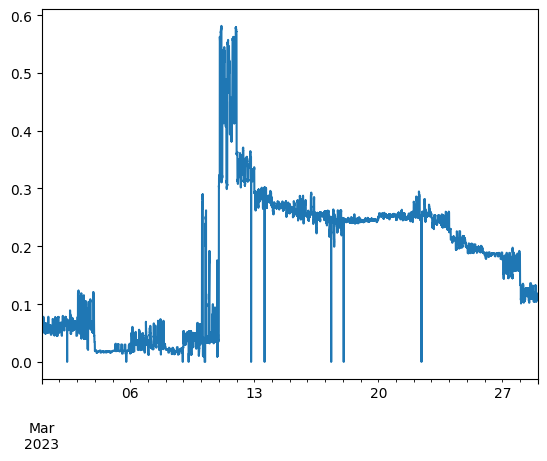

In [33]:
metrics_df['giniCoefficient'].plot()

In [171]:
STEP_SIZE = 10 # NOTE: increasing this risks losing txs, 10 is probably safe
start = datetime(2023, 3, 10)
start_timestamp, start_block = DataFetcher.get_block(start)
end = datetime(2023, 3, 10, 1)
end_timestamp, end_block = DataFetcher.get_block(end)

datafetcher = DataFetcher(token_metadata=token_metadata)

pool = '0xceaf7747579696a2f0bb206a14210e3c9e6fb269'
token = '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48'

In [100]:
token_data = datafetcher.get_ohlcv(start_timestamp, end_timestamp, token)
pool_data = datafetcher.get_pool_data(start_block, end_block, pool, step_size=1)
swaps_data = datafetcher.get_swaps_data(start_block, end_block, pool, step_size=STEP_SIZE)
lp_data = datafetcher.get_lp_data(start_block, end_block, pool, step_size=STEP_SIZE)

Fetching OHLCV for USDC/USD using Binance US...
Fetching OHLCV for USDC/USD using Binance US...


In [80]:
token_data_df = RawDataHandler.format_token_data(token_data)
pool_df = RawDataHandler.format_pool_data(pool_data, datafetcher.start_timestamp, datafetcher.end_timestamp)
swaps_df = RawDataHandler.format_swaps_data(swaps_data)
lp_df = RawDataHandler.format_lp_data(lp_data)

In [165]:
exchange = ccxt.mexc3()
exchange.fetch_ohlcv("USDN/USDT", since=1667339268*1000, timeframe='1d', limit=100)

[[1674950400000, 0.3319, 0.3394, 0.3315, 0.3327, 124904.57],
 [1675036800000, 0.3327, 0.3354, 0.3117, 0.318, 130005.85],
 [1675123200000, 0.318, 0.3284, 0.3033, 0.3149, 132879.22],
 [1675209600000, 0.3149, 0.323, 0.2951, 0.2998, 140914.08],
 [1675296000000, 0.2998, 0.32, 0.2941, 0.3098, 140465.8],
 [1675382400000, 0.3098, 0.32, 0.2987, 0.312, 137210.38],
 [1675468800000, 0.312, 0.3283, 0.3096, 0.3256, 130469.71],
 [1675555200000, 0.3256, 0.3347, 0.3055, 0.3066, 134655.62],
 [1675641600000, 0.3066, 0.3235, 0.2826, 0.3197, 134920.22],
 [1675728000000, 0.3197, 0.3397, 0.3065, 0.309, 131385.31],
 [1675814400000, 0.309, 0.3221, 0.2886, 0.3126, 106492.31],
 [1675900800000, 0.3126, 0.3543, 0.3122, 0.3212, 132661.06],
 [1675987200000, 0.3212, 0.3235, 0.3062, 0.3121, 94012.65],
 [1676073600000, 0.3121, 0.3132, 0.2767, 0.2907, 140485.95],
 [1676160000000, 0.2907, 0.2954, 0.2714, 0.2769, 141418.0],
 [1676246400000, 0.2769, 0.2825, 0.2701, 0.2786, 147060.05],
 [1676332800000, 0.2786, 0.2787, 0.261

In [34]:
for exchange_id in ccxt.exchanges:
    exchange = getattr(ccxt, exchange_id)()
    try:
        exchange.load_markets()
        for market in exchange.markets.keys():
            if "USDN" in market or "USDn" in market:
                print(f'{exchange_id}, {market}')
    except Exception as e:
        print(f'{exchange_id}, failed.')

binance, failed.
binancecoinm, failed.
binanceusdm, failed.
bitflyer, failed.
bittrex, USDN/BTC
bittrex, USDN/USDT
coinbase, failed.
gate, USDN/USDT
gateio, USDN/USDT
hitbtc, USDN/USDT
hitbtc3, USDN/USDT
kuna, failed.
mexc, USDN/USDT
mexc3, USDN/USDT
okcoin, failed.
tidex, failed.
tokocrypto, failed.


# Missing Txs
We show that if you increase the step_size between block_gte and block_lt you start losing transactions because theGraph has a rate limit of 100 rows per response.

In [ ]:
start = datetime(2023, 3, 11)
end = datetime(2023, 3, 13)
datafetcher = DataFetcher(start, end)
_3pool = '0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7'

In [ ]:
swaps_data_1 = datafetcher.get_swaps_data('3pool', step_size=1)
swaps_data_10 = datafetcher.get_swaps_data('3pool', step_size=10)
swaps_data_50 = datafetcher.get_swaps_data('3pool', step_size=50)
swaps_data_100 = datafetcher.get_swaps_data('3pool', step_size=100)

swaps_df_1 = RawDataHandler.format_swaps_data(swaps_data_1)
swaps_df_10 = RawDataHandler.format_swaps_data(swaps_data_10)
swaps_df_50 = RawDataHandler.format_swaps_data(swaps_data_50)
swaps_df_100 = RawDataHandler.format_swaps_data(swaps_data_100)

print(swaps_df_1.shape)
print(swaps_df_10.shape)
print(swaps_df_50.shape)
print(swaps_df_100.shape)

In [59]:
missing = set(swaps_df_10['id']) - set(swaps_df_100['id'])
missing_eg = missing.pop()
swaps_df_10[swaps_df_10['id']==missing_eg]

,id,amountBought,amountSold,block,buyer,gasLimit,gasUsed,isUnderlying,timestamp,tokenBought,tokenSold,tx,pool_id,block_gte,block_lt
16058,0xdc50a0d779d4c5792f32e1a9a5ba2914f58aa654bb79...,340929.942491,331341.859263,16804730,0xdecf04ca46d287b3cb99692ad512e568ba276140,601141,360441,0,1678536347,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0x6b175474e89094c44da98b954eedeac495271d0f,0xdc50a0d779d4c5792f32e1a9a5ba2914f58aa654bb79...,0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7,16804724,16804734


In [78]:
CURVE_SUBGRAPH_URL_CVX = 'https://api.thegraph.com/subgraphs/name/convex-community/curve-mainnet'
block = 16804725
query = queries['swapEvents']
kwargs = {'pool_id':'0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7', 'block_gte':block, 'block_lt':block+40}
out = await datafetcher.execute_query_async(query, 'swapEvents', CURVE_SUBGRAPH_URL_CVX, **kwargs)
out_df = RawDataHandler.format_swaps_data([out])
print(len(out_df))
# out_df[out_df['id'] == '0xdc50a0d779d4c5792f32e1a9a5ba2914f58aa654bb79ad59d0daf319692bac5b-340929.942491-131']

89


In [45]:
CURVE_SUBGRAPH_URL_CVX = 'https://api.thegraph.com/subgraphs/name/convex-community/curve-mainnet'
query = queries['swapEvents']
kwargs = {'pool_id':'0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7', 'block_gte':16804686, 'block_lt':16804735}
out = await datafetcher.execute_query_async(query, 'swapEvents', CURVE_SUBGRAPH_URL_CVX, **kwargs)
out_df = RawDataHandler.format_swaps_data([out])
out_df[out_df['id'] == '0xdc50a0d779d4c5792f32e1a9a5ba2914f58aa654bb79ad59d0daf319692bac5b-340929.942491-131']

,id,amountBought,amountSold,block,buyer,gasLimit,gasUsed,isUnderlying,timestamp,tokenBought,tokenSold,tx,pool_id,block_gte,block_lt
